In [1]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import IPython.display as display

from classes import *
from gen_utils import *
from tqdm import tqdm
from utils import *

# minihack env creation with a .des file

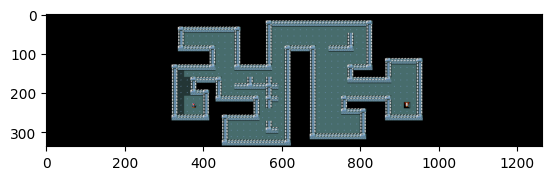

In [2]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "maps/complex_maze.des",
    max_episode_steps=10000,
)
state = env.reset()
#env.render()
plt.imshow(state['pixel'])

In [3]:
state = env.reset()
game_map = state['chars']
game = state['pixel']
start = get_player_location(game_map)
target = get_target_location(game_map)

map = Map(game_map, start, target)

In [4]:
print(f"> start: {map.start}, target: {map.target}")

> start: (14, 23), target: (14, 57)


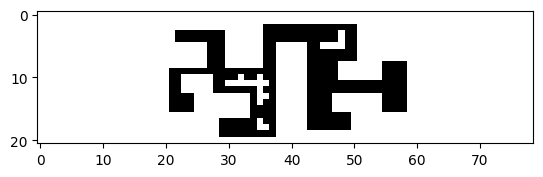

In [5]:
# print the map_matrix with matplotlib where the walls are black and the floor is white
plt.imshow(map.map_matrix, cmap='gray')
plt.show()


In [6]:
individual = Individual(random_nactions(), 1, map)

In [7]:
individual.path[0] == map.start

False

# We have to decide if we want to generate a random path or random actions

random path $\Rightarrow$ a path of exactly n steps

random actions $\Rightarrow$ many action will be not valid $\Rightarrow$ the path will be shorter OR, as is implemented now, with many repetition of the same position.

# NOTE:
minihack wont crash if we input a not valid action starting from a valid action. It will simply not execute the action (as if we are playing), hence we are updating the path position with the same position.

In [8]:
#random_nsteps(game_map, start, target) # RANDOM VALID PATH
random_nactions()                      # RANDOM (TO CHECK VALIDITY) ACTIONS

[1,
 0,
 2,
 1,
 1,
 2,
 2,
 3,
 2,
 3,
 0,
 1,
 0,
 3,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 3,
 3,
 1,
 3,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 2,
 1,
 2,
 1,
 0,
 0,
 2,
 2,
 3,
 0,
 2,
 1,
 0,
 1,
 1,
 2,
 0,
 1,
 3,
 3,
 3,
 0,
 2,
 0,
 3,
 0,
 2,
 0,
 3,
 2,
 3,
 0,
 3,
 3,
 0,
 1,
 2,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 3,
 3,
 3,
 3,
 0,
 1,
 3,
 2,
 3,
 3,
 3,
 1,
 2,
 3,
 2,
 1,
 2,
 1]

In [9]:
individual = Individual(random_nactions(), 1, map)
individual1 = Individual(random_nactions(), 1, map)
len(crossover_uniform(individual.actions, individual1.actions))

100

In [10]:
count_loops(individual.path)

71

In [11]:
random.random()

0.6165157779401274

In [12]:
# create first generation
MAX_GENERATIONS = 1000
MAX_INDIVIDUALS = 100
best_individuals = []

print("> Creating initial population...")
individuals = [Individual(random_nactions(), 1, map) for _ in range(MAX_INDIVIDUALS)]
individuals.sort(key=lambda x: x.fitness, reverse=False)
#print(f'best_individual: {individuals[0].fitness}')
print("> Evolving...")

for generation in tqdm(range(MAX_GENERATIONS)):

    best_fitness = individuals[0].fitness
    best_individuals.append(individuals[0]) 
    if generation % 100 == 0:
        print(f'best_individual in generation {generation}: fitness: {best_fitness}, wrong actions: {individuals[0].wrong_actions}, loops: {individuals[0].loops}')

    # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
    # also roulette wheel selection.
    child1, child2 = individuals[0].actions, individuals[1].actions
    offspring = [crossover_uniform(child1, child2) for _ in range(MAX_INDIVIDUALS)]
    offspring = [mutate(child, valid_actions_bitmap(map.start, path_from_actions(map.map, map.start, child)[0])) for child in offspring]

    individuals[2:] = [Individual(offspring[i], generation+1, map) for i in range(MAX_INDIVIDUALS-2)]
    individuals.sort(key=lambda x: x.fitness, reverse=False)

    # print every individual fitness
    """for i in range(MAX_INDIVIDUALS):
        print(f"Individual {i} fitness: {individuals[i].fitness}")
"""
    # print(f"Generation {generation}: best score {best_fitness:.2f}")
    """
    if best_fitness == 0:
        zero_fitness.append(population[0][0])"""
best_fitness = individuals[0].fitness
best_individuals.append(individuals[0])
print(f'best_individual in generation {generation}: {best_fitness}, wrong actions: {individuals[0].wrong_actions}')



> Creating initial population...
> Evolving...


  0%|          | 3/1000 [00:00<00:41, 24.03it/s]

best_individual in generation 0: fitness: 83.3, wrong actions: 17, loops: 58


 10%|█         | 105/1000 [00:04<00:34, 25.77it/s]

best_individual in generation 100: fitness: 18.4, wrong actions: 24, loops: 20


 20%|██        | 204/1000 [00:08<00:32, 24.70it/s]

best_individual in generation 200: fitness: 9.4, wrong actions: 18, loops: 18


 30%|███       | 303/1000 [00:12<00:30, 23.04it/s]

best_individual in generation 300: fitness: 9.2, wrong actions: 18, loops: 17


 40%|████      | 402/1000 [00:16<00:26, 22.92it/s]

best_individual in generation 400: fitness: 9.2, wrong actions: 18, loops: 17


 50%|█████     | 504/1000 [00:21<00:21, 22.85it/s]

best_individual in generation 500: fitness: 9.2, wrong actions: 18, loops: 17


 61%|██████    | 606/1000 [00:25<00:16, 24.38it/s]

best_individual in generation 600: fitness: 9.2, wrong actions: 18, loops: 17


 70%|███████   | 702/1000 [00:29<00:12, 24.41it/s]

best_individual in generation 700: fitness: 9.2, wrong actions: 18, loops: 17


 80%|████████  | 804/1000 [00:33<00:08, 23.26it/s]

best_individual in generation 800: fitness: 8.4, wrong actions: 20, loops: 12


 91%|█████████ | 906/1000 [00:38<00:03, 24.43it/s]

best_individual in generation 900: fitness: 8.2, wrong actions: 14, loops: 14


100%|██████████| 1000/1000 [00:42<00:00, 23.81it/s]

best_individual in generation 999: 8.2, wrong actions: 14


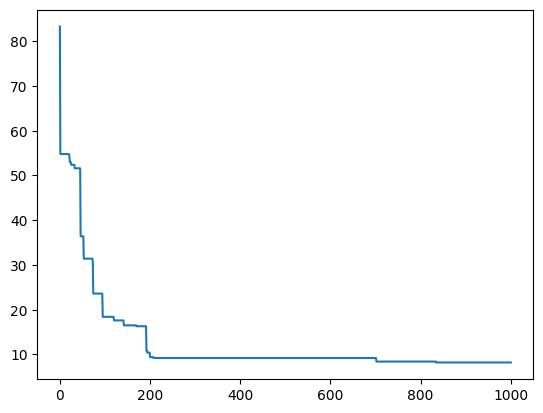

In [13]:
# Plot for each generation the best fitness
best_fitness = [best_individuals[i].fitness for i in range(len(best_individuals))]
plt.plot(best_fitness)

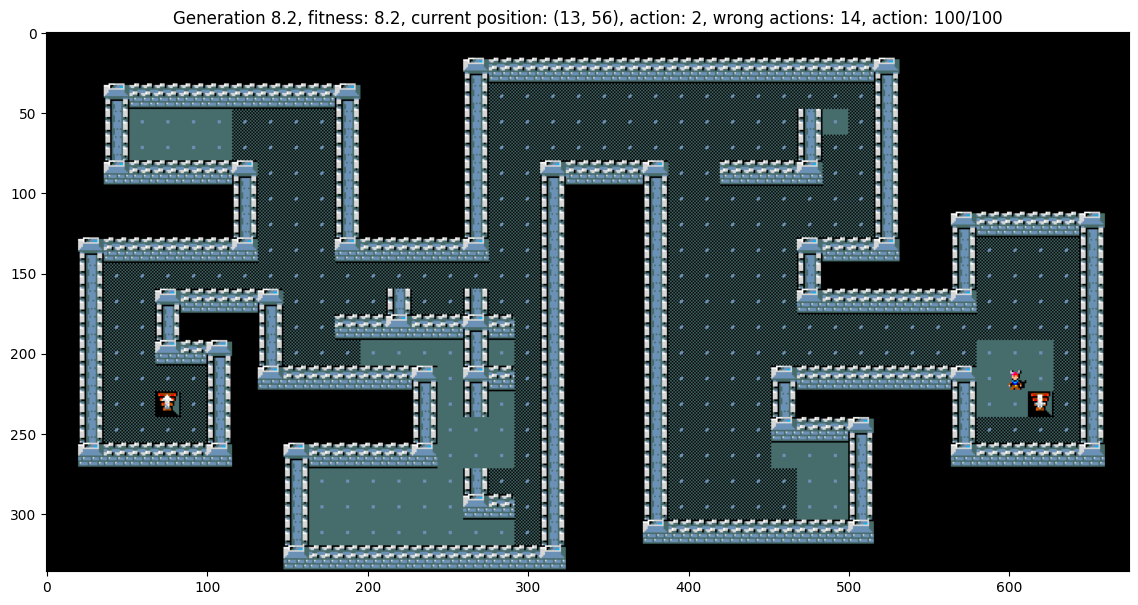

In [14]:
env.reset()
plt.rcParams['figure.figsize'] = [17, 7]

image = plt.imshow(game[:, 300:975])
# for generation, path in enumerate(best_paths):
# plt.title(f"Generation {generation}, fitness: {best_scores[generation]:.2f}, last move: {path[-1]}")
#start = best_paths[0]
#path = best_paths[-1]
actions = []
actions = individuals[0].actions
wrong = 0

for i, action in enumerate(actions):
    try: 
        s, _, _, _ = env.step(action)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.title(f"Generation {individuals[0].fitness}, fitness: {individuals[0].fitness}, current position: {individuals[0].path[i]}, action: {action}, wrong actions: {wrong}, action: {i+1}/{len(actions)}")
        image.set_data(s['pixel'][:, 300:975])
        #time.sleep(0.1)
        if individuals[0].path[i] == map.target:
            print('YOU WON! <3')
            break
        if individuals[0].path[i] == individuals[0].path[i-1]:
            wrong += 1
    except RuntimeError:
        print('YOU WON! <3')

In [16]:
target

(14, 57)

In [15]:
"""MAX_GENERATIONS = 1000
MAX_INDIVIDUALS = 100

best_scores =[]
best_paths = []
zero_fitness = []

# create a list of individuals, starting with random moves (illegal actions filtered out)
print("> Creating initial population...")
individuals = [random_nsteps(game_map, start, target) for _ in range(MAX_INDIVIDUALS)]
best_fitness = np.inf

print("> Evolving...")
for generation in tqdm(range(MAX_GENERATIONS)):
    
    generation_scores = []

    #fitnesses = [fitness_function(individual, checkpoints, generation) for individual in individuals]
    #fitness_function = lambda path: abs(path[-1][0] - target[0]) + abs(path[-1][1] - target[1])

    ind_actions = [actions_from_path(start, ind) for ind in individuals]
    generation_scores.append(min(fitnesses))

    # this is a list of tuples (individual, fitness). individual is a list of moves
    population = list(zip(individuals, fitnesses))
    actions =  list(zip(ind_actions, fitnesses))

    # sorting the population by best fitness (lower is better)
    population.sort(key=lambda x: x[1])
    actions.sort(key=lambda x:x[1])
    # sort ind_actions with respect to population
    
    #print(f"best score: {population[0][1]:.2f}")

    # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
    # also roulette wheel selection.

    child1, child2, = actions[0][0], actions[1][0]

    offspring = [crossover(child1, child2) for _ in range(MAX_INDIVIDUALS)]
    offspring = [mutate(child) for child in offspring]
    ind_actions = offspring
    individuals = [path_from_actions(game_map, start, child) for child in offspring]

    best_fitness = population[0][1]
    best_scores.append(population[0][1])    
    best_paths.append(population[0][0])
    #print(f"Generation {generation}: best score {best_fitness:.2f}")

    if best_fitness == 0:
        zero_fitness.append(population[0][0])
    
# print best score and best path
best_idx = np.argmin(best_scores)
print(f"Best score: {best_scores[best_idx]:.2f}")
print(f"Best path: {best_paths[best_idx]}")
print(f"generation of best path: {best_idx}")"""

'MAX_GENERATIONS = 1000\nMAX_INDIVIDUALS = 100\n\nbest_scores =[]\nbest_paths = []\nzero_fitness = []\n\n# create a list of individuals, starting with random moves (illegal actions filtered out)\nprint("> Creating initial population...")\nindividuals = [random_nsteps(game_map, start, target) for _ in range(MAX_INDIVIDUALS)]\nbest_fitness = np.inf\n\nprint("> Evolving...")\nfor generation in tqdm(range(MAX_GENERATIONS)):\n    \n    generation_scores = []\n\n    #fitnesses = [fitness_function(individual, checkpoints, generation) for individual in individuals]\n    #fitness_function = lambda path: abs(path[-1][0] - target[0]) + abs(path[-1][1] - target[1])\n\n    ind_actions = [actions_from_path(start, ind) for ind in individuals]\n    generation_scores.append(min(fitnesses))\n\n    # this is a list of tuples (individual, fitness). individual is a list of moves\n    population = list(zip(individuals, fitnesses))\n    actions =  list(zip(ind_actions, fitnesses))\n\n    # sorting the popula